# Deep Learning with PyTorch : Build an AutoEncoder

An autoencoder is a type of neural network that learns to copy its input to its output. In autoencoder, encoder encodes the image into compressed representation, and the decoder decodes the representation.

![](denoising_autoencoder.png)

Applications of AutoEncoder:

- Segmentation
- Denoising Image
- Super Resolution Image
- Image Compression
- and many more .....

In this Project, you will see the simplest implemention of autoencoder for image denoising task.

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

# Exploring Dataset 

In [2]:
data = pd.read_csv('mnist_dataset.csv')
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


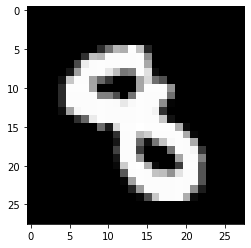

In [9]:
image = np.array(data.iloc[67]).astype('float32').reshape(28,28)
image = image / 255
plt.imshow(image, cmap='gray')

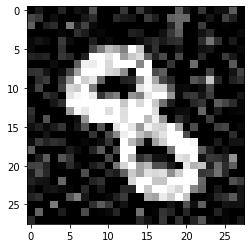

In [16]:
noisy_image = image + 0.2 * np.random.randn(*image.shape)
noisy_image = np.clip(noisy_image, 0, 1)
plt.imshow(noisy_image, cmap='gray')

In [13]:
print(*image.shape)

28 28


# Data Preparation 

In [17]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

<img src="dataset.png" alt="drawing" width="400"/>

In [24]:
class MNIST_AE_Dataset(Dataset):
    
    def __init__(self, csv_file, noise_factor = 0.2, transform = None):
        
        self.data = pd.read_csv(csv_file)
        self.noise_factor = noise_factor
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img, (28, 28, 1))/255
        
        noisy_img = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        
        sample = (noisy_img, img)
        if self.transform:
            sample = self.transform(sample)
        
        return sample

### **Here to ToTensorForAE() is a custom transform which will convert numpy,PIL image to torch tensor and also it will convert image with (height,width,channel) to (channel,height,width) as per the pytorch model input convention.**

For eg, numpy array image with shape (28,28,1) will be first converted to image torch tensor with shape(28,28,1)
and then the channel is shifted to 0th axis so image tensor will be with shape (1,28,28)

In [25]:
train = MNIST_AE_Dataset('mnist_dataset.csv', transform=ToTensorForAE())

In [26]:
print(len(train))

42000


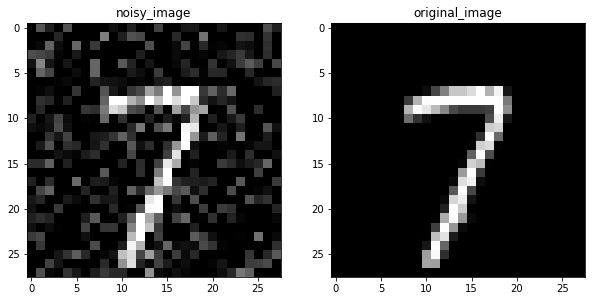

In [27]:
noisy_img, orig_img = train[18]
show_image(noisy_img, orig_img)

# Load dataset into batches

In [28]:
from torch.utils.data import DataLoader

In [29]:
trainloader = DataLoader(train, batch_size=16, shuffle=True)

In [34]:
dataiter = iter(trainloader)
noisy_img, orig_img = dataiter.next()

print(noisy_img.shape)
print(len(trainloader))
print(len(trainloader.dataset))

torch.Size([16, 1, 28, 28])
2625
42000


# Create AutoEncoder Model

In [35]:
from torch import nn
from torchsummary import summary

In [40]:
def encoder():
    
    enc = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3, 3), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2)),
        
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2))
    )
    
    return enc


In [41]:
def decoder():
    
    dec = nn.Sequential(
        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (2, 2), stride = 2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels = 16, out_channels = 1, kernel_size = (2, 2), stride = 2),
        nn.Sigmoid()
    )
    
    return dec

In [42]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder()
        self.decoder = decoder()
        
    def forward(self, inp_imgs):
        
        encoder_output = self.encoder(inp_imgs)
        decoder_output = self.decoder(encoder_output)
        
        return decoder_output
    
model = AutoEncoder()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [43]:
summary(model, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

/home/rhyme/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Train AutoEncoder Model 

In [44]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
epochs = 10

In [45]:
for i in range(epochs):
    
    train_loss = 0.0
    
    model.train()
    for batch in tqdm(trainloader):
        
        noisy_img, org_img = batch
        
        denoised_img = model(noisy_img)
        loss = criterion(denoised_img, org_img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss/len(trainloader)
    
    
    print('Epoch : {} training loss: {}'.format(i+1, avg_train_loss))
        

  0%|          | 6/2625 [00:00<00:50, 51.95it/s]

Epoch : 1 training loss: 0.017014897125285297


  0%|          | 8/2625 [00:00<00:33, 78.00it/s]

Epoch : 2 training loss: 0.00577113939520149


  0%|          | 8/2625 [00:00<00:33, 77.11it/s]

Epoch : 3 training loss: 0.0053082690767589065


  0%|          | 8/2625 [00:00<00:33, 77.59it/s]

Epoch : 4 training loss: 0.005080430070026999


  0%|          | 8/2625 [00:00<00:33, 78.10it/s]

Epoch : 5 training loss: 0.004926667619319189


  0%|          | 8/2625 [00:00<00:33, 78.66it/s]

Epoch : 6 training loss: 0.004808374424331955


  0%|          | 8/2625 [00:00<00:36, 72.08it/s]

Epoch : 7 training loss: 0.00472226319799111


  0%|          | 9/2625 [00:00<00:32, 80.66it/s]

Epoch : 8 training loss: 0.00465664928202473


  0%|          | 8/2625 [00:00<00:33, 79.19it/s]

Epoch : 9 training loss: 0.004600143459049009


100%|██████████| 2625/2625 [00:31<00:00, 83.37it/s]

Epoch : 10 training loss: 0.004563005395765815


# Plot Results

torch.Size([1, 28, 28])


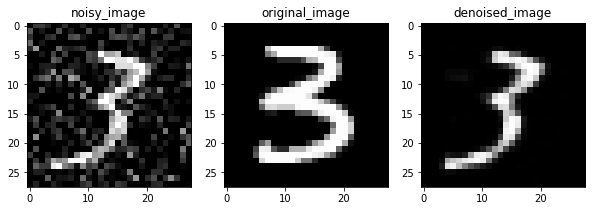

In [50]:
model.eval()

with torch.no_grad():
    
    dataiter = iter(trainloader)
    sample = dataiter.next()
    
    noisy_img, org_img = sample
    
    index = 4
    
    denoised_img = model(noisy_img[index].unsqueeze(0))
    
    print(denoised_img.squeeze(0).shape)
    
    show_image(noisy_img[index], orig_img[index], denoised_img.squeeze(0))